In [1]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial + Tensorboard
==============================================
Two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

['ants', 'bees']
cpu


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



torch.Size([3, 228, 906])
(228, 906, 3)


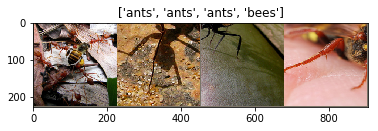

In [55]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    print(inp.shape)
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNet as fixed feature extractor, i.e. tune the last layer
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [13]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to model_ft.parameters() which observe that all parameters 
# are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/p787144/.cache/torch/checkpoints/resnet18-5c106cde.pth


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6306 Acc: 0.6680
val Loss: 0.2141 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4367 Acc: 0.7869
val Loss: 0.1767 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4540 Acc: 0.7992
val Loss: 0.1875 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5202 Acc: 0.7787
val Loss: 0.2026 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3885 Acc: 0.8156
val Loss: 0.1906 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4729 Acc: 0.8115
val Loss: 0.1871 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4369 Acc: 0.8156
val Loss: 0.1633 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3261 Acc: 0.8607
val Loss: 0.1994 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3225 Acc: 0.8402
val Loss: 0.1922 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2534 Acc: 0.8934
val Loss: 0.1711 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3610 Acc: 0.8320
val Loss: 0.1915 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3687 Acc: 0.8443
val Loss: 0.1702 Acc: 0.9477

Ep

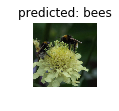

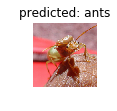

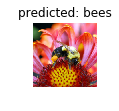

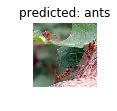

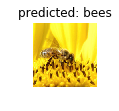

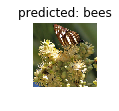

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# The code below for Tensorboard is copied from https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html and taliored for the data structure of this project

## 1. TensorBoard setup
Now we’ll set up TensorBoard, importing tensorboard from torch.utils and defining a SummaryWriter, our key object for writing information to TensorBoard.

In [49]:
# May see such error https://github.com/pytorch/pytorch/issues/20140
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/ants_vs_bees')

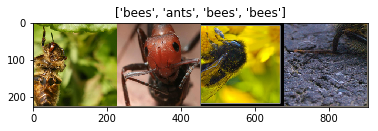

In [52]:
# We have run this line before. Just to see again.
imshow(out, title=[class_names[x] for x in classes])

## 2. Write to tensorboard

In [53]:
# write to tensorboard
writer.add_image('ants_vs_bees_images', out)

## The following one line will need to be run (and navigate to https://localhost:6006) to see Tensorboard, and interrupted to run new lines below

In [109]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.2.0a20200215 at http://localhost:6006/ (Press CTRL+C to quit)
W0216 19:15:53.810178 123145462329344 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0216 19:15:53.810416 123145462329344 plugin_event_accumulator.py:362] Found more than one "run metadata" event with tag step1. Overwriting it with the newest event.
W0216 19:15:53.834100 123145462329344 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0216 19:15:53.834290 123145462329344 plugin_event_accumulator.py:362] Found more than one "run metadata" eve

## 3. Inspect the model using TensorBoard

In [60]:
writer.add_graph(model_conv, inputs)
writer.close()

## 4. Adding a “Projector” to TensorBoard (to be done)
## 5. Tracking model training with TensorBoard
There is a far nicer demo of this functionality in the original tutorial.

In [83]:
# The two functions below is for showing the model's predictions on a random mini-batch


# def images_to_probs(net, images):
#     '''
#     Generates predictions and corresponding probabilities from a trained
#     network and a list of images
#     '''
#     output = net(images)
#     # convert output probabilities to predicted class
#     _, preds_tensor = torch.max(output, 1)
#     preds = np.squeeze(preds_tensor.numpy())
#     return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


# def plot_classes_preds(net, images, labels):
#     '''
#     Generates matplotlib Figure using a trained network, along with images
#     and labels from a batch, that shows the network's top prediction along
#     with its probability, alongside the actual label, coloring this
#     information based on whether the prediction was correct or not.
#     Uses the "images_to_probs" function.
#     '''
#     preds, probs = images_to_probs(net, images)
#     # plot the images in the batch, along with predicted and true labels
#     fig = plt.figure(figsize=(12, 48))
#     for idx in np.arange(4):
#         ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
#         matplotlib_imshow(images[idx], one_channel=True)
#         ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
#             classes[preds[idx]],
#             probs[idx] * 100.0,
#             classes[labels[idx]]),
#                     color=("green" if preds[idx]==labels[idx].item() else "red"))
#     return fig

In [85]:
def train_model_with_tensorboard(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
                
            
            ####### The addition to the original func, for plotting on tensorboard
            # ...log the running loss
            # On tensorboard, the loss of train and val are plotted 
            # together in this case, forming a squiggling line.
            # When set smoothing to 0, will see exactly the train/val
            # loss values on the plot.
            writer.add_scalar('training loss', epoch_loss, epoch)
            #################################################
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [88]:
model_conv = train_model_with_tensorboard(
    model_conv, criterion, optimizer_conv,
    exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.3164 Acc: 0.8402
val Loss: 0.1791 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.2914 Acc: 0.8730
val Loss: 0.1964 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3246 Acc: 0.8607
val Loss: 0.1560 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.3987 Acc: 0.8197
val Loss: 0.1768 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3301 Acc: 0.8689
val Loss: 0.1753 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3451 Acc: 0.8443
val Loss: 0.1710 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2634 Acc: 0.9139
val Loss: 0.1821 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3054 Acc: 0.8730
val Loss: 0.1625 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3650 Acc: 0.8238
val Loss: 0.1602 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3304 Acc: 0.8361
val Loss: 0.1680 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3000 Acc: 0.8689
val Loss: 0.1884 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3636 Acc: 0.8115
val Loss: 0.1670 Acc: 0.9477

Ep

<br>
<br>

## 6. Assessing trained models with TensorBoard

In [111]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor

class_probs = []
class_preds = []

model_conv.eval()    
    
with torch.no_grad():
    
    for inputs, labels in dataloaders["val"]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_conv(inputs)
    
#     for data in testloader:
#         images, labels = data
#         output = net(images)

        class_probs_batch = [nn.functional.softmax(el, dim=0) for el in outputs]
        _, class_preds_batch = torch.max(outputs, 1)

        class_probs.append(class_probs_batch)
        # HAVE CONFLICT WITH THE CODE TEMPLATE
        # PYTORCH TUTORIAL USES THE BELOW LINE
        #class_preds.append(class_preds_batch)
        # BUT I THINK THE BELOW IS INSTEAD CORRECT
        class_preds.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" and plots the corresponding precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(class_names[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(class_names)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

In [113]:
class_preds[0:5]

[tensor([1, 1, 0, 1]),
 tensor([1, 0, 1, 0]),
 tensor([0, 1, 1, 0]),
 tensor([1, 0, 1, 0]),
 tensor([0, 1, 1, 1])]

In [117]:
len(class_preds)

39

In [114]:
class_probs[0:5]

[[tensor([0.0095, 0.9905]),
  tensor([0.0011, 0.9989]),
  tensor([0.8750, 0.1250]),
  tensor([0.0030, 0.9970])],
 [tensor([0.0073, 0.9927]),
  tensor([0.7333, 0.2667]),
  tensor([0.0081, 0.9919]),
  tensor([0.9373, 0.0627])],
 [tensor([0.9767, 0.0233]),
  tensor([0.1579, 0.8421]),
  tensor([0.1488, 0.8512]),
  tensor([0.8353, 0.1647])],
 [tensor([1.2595e-04, 9.9987e-01]),
  tensor([0.9983, 0.0017]),
  tensor([0.4524, 0.5476]),
  tensor([0.9387, 0.0613])],
 [tensor([0.9947, 0.0053]),
  tensor([0.0057, 0.9943]),
  tensor([0.0032, 0.9968]),
  tensor([0.2637, 0.7363])]]

In [118]:
len(class_probs)

39

In [115]:
test_preds[0:5]

tensor([1, 1, 0, 1, 1])

In [119]:
len(test_preds)

153

In [116]:
test_probs[0:5]

tensor([[0.0095, 0.9905],
        [0.0011, 0.9989],
        [0.8750, 0.1250],
        [0.0030, 0.9970],
        [0.0073, 0.9927]])

In [120]:
len(test_probs)

153